## Lecture 3.3 Linear Regression Demonstration
### Linear Regression with sklearn API
The objective of this notebook is to demonstrate how to build a linear regression model with ``sklearn``. We will be using the following setup:
- Dataset: California housing
- Linear Regression API: ``LinearRegression``
- Training: ``fit`` (normal equation) and ``cross_validate`` (normal equation with cross validation)
- Evaluation: ``score`` (r2 score) and ``cross_val_score`` with different scoring parameters.

We will study the model diagnosis with ``Learning Curve`` and learn how to examine the learned model or weight vector.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import  ShuffleSplit

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(306)
plt.style.use('seaborn')

We will use ``ShuffleSplit`` cross validation with:
- 10 folds (``n_splits``) and
- set aside 20% examples as test examples (``test_size``).

In [3]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size= 0.2, random_state=0)

Creates 10 folds through shuffle splits by keeping 20% examples as test in each fold.

### **STEP 1**: Load the dataset
The first step is to load the dataset.

In [4]:
features, labels = fetch_california_housing(as_frame=True, return_X_y= True)

The feature matrix is loaded in ``features`` dataframe and the ``labels`` dataframe. Let's examine the shapes of these two dataframes.

In [5]:
print('Shape of feature matrix:',features.shape)
print('Shape of label vector:',labels.shape)

Shape of feature matrix: (20640, 8)
Shape of label vector: (20640,)


As a sanity check, let's make sure that the number of examples in feature matrix and label vector match.

In [6]:
assert(features.shape[0] == labels.shape[0])

### **STEP 2**: Data exploration.

In [7]:
?fetch_california_housing

Signature:
fetch_california_housing(
    *,
    data_home=None,
    download_if_missing=True,
    return_X_y=False,
    as_frame=False,
)
Docstring:
Load the California housing dataset (regression).

==============   ==============
Samples total             20640
Dimensionality                8
Features                   real
Target           real 0.15 - 5.
==============   ==============

Read more in the :ref:`User Guide <california_housing_dataset>`.

Parameters
----------
data_home : str, default=None
    Specify another download and cache folder for the datasets. By default
    all scikit-learn data is stored in '~/scikit_learn_data' subfolders.

download_if_missing : bool, default=True
    If False, raise a IOError if the data is not locally available
    instead of trying to download the data from the source site.


return_X_y : bool, default=False.
    If True, returns ``(data.data, data.target)`` instead of a Bunch
    object.

    .. versionadded:: 0.20

as_frame : bool, defa

Note that ``fetch_*`` also returns a ``Bunch`` object just like loaders.

We can examine various attributes of this dataset on the lines of datasets in loaders.

In [8]:
# Call the loader and obtain the `Bunch` object
housing_data = fetch_california_housing()

Let's examine the bunch object

We can do that by looking at the description of this dataset.

In [9]:
housing_data.DESCR

'.. _california_housing_dataset:\n\nCalifornia Housing dataset\n--------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 20640\n\n    :Number of Attributes: 8 numeric, predictive attributes and the target\n\n    :Attribute Information:\n        - MedInc        median income in block\n        - HouseAge      median house age in block\n        - AveRooms      average number of rooms\n        - AveBedrms     average number of bedrooms\n        - Population    block population\n        - AveOccup      average house occupancy\n        - Latitude      house block latitude\n        - Longitude     house block longitude\n\n    :Missing Attribute Values: None\n\nThis dataset was obtained from the StatLib repository.\nhttp://lib.stat.cmu.edu/datasets/\n\nThe target variable is the median house value for California districts.\n\nThis dataset was derived from the 1990 U.S. census, using one row per census\nblock group. A block group is the smallest geographical unit

Find out the shape of matrix

In [10]:
housing_data.data.shape

(20640, 8)

Let's take a look at first 5 examples of the feature matrix

In [11]:
housing_data.data[:5]

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])

Let's find out the shape of label matrix.

In [12]:
housing_data.target.shape

(20640,)

Let's take a look at the first five examples in label vector.

In [13]:
housing_data.target[:5]

array([4.526, 3.585, 3.521, 3.413, 3.422])

find out the names of the features.

In [14]:
housing_data.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

Find the names of labels class

In [15]:
housing_data.target_names

['MedHouseVal']

### **STEP 3**: Preprocessing and model building
#### 3.1 Train Test Split
The first step is to split the training data into training and test set. We do not access the test data till the end. All the data exploration and tuning is performed on the training set and by setting aside a portion of training as a dev or validation set.

The following code snippet will divide the data into training and test sets.

In [16]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
                                features, labels, random_state=42)

Let's examine the shapes of traning and test sets

In [17]:
print('Training data shape:', train_features.shape)
print('Traning labels shape:', train_labels.shape)
print('Test data shape:', test_features.shape)
print('Test labels shape:', test_labels.shape)

Training data shape: (15480, 8)
Traning labels shape: (15480,)
Test data shape: (5160, 8)
Test labels shape: (5160,)


Let's perform a sanity check - here we check if the training feature matrix has the same number of rows as the training label vector. We shall apply the same on the test sets

In [18]:
assert(train_features.shape[0] == train_labels.shape[0])
assert(test_features.shape[0] == test_labels.shape[0])

#### 3.2 Pipeline: preprocessing + model
As a first step, build linear regression models with default parameter setting of ``LinearRegression`` APIs

> We will make use of ``Pipeline`` API for combining data preprocessing and model building.

We will use ``StandardScaler`` feature scaling to bring all the features on the same scale followed by ``LinearRegression`` model.

The ``pipeline`` object has two components.
1. ``StandardScaler`` as step 1.
2. ``LinearRegression`` as step 2.

After constructing the pipeline object, let's train it with training set.

In [19]:
# setup the linear regression model.
lin_reg_pipeline = Pipeline([('feature_scaling',StandardScaler()),
                            ('lin_reg',LinearRegression())])

lin_reg_pipeline.fit(train_features,train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])

Now that we have trained the model. Let's check the learnt/estimated weight vectors (``intercerpt_`` and ``coef_``)

In [20]:
print('Intercept (w_0):', lin_reg_pipeline[-1].intercept_)
print('weight vector [w_1, w_2,...,w_m]:', lin_reg_pipeline[-1].coef_)

Intercept (w_0): 2.0703489205426377
weight vector [w_1, w_2,...,w_m]: [ 0.85210815  0.12065533 -0.30210555  0.34860575 -0.00164465 -0.04116356
 -0.89314697 -0.86784046]


A couple of things to notice:
- We accessed the ``LinearRegression`` object as ``lin_reg_pipeline[-1]`` which is the last step in the pipeline.
- The intercept can be obtained via ``intercept_`` member variable and
- The weight vector corresponding to features via ``coef_``.

### **STEP 4**: Model evaluation
#### ``score``
Let's use the ``score`` method to obtain train and test errors with twin objectives.
> - Estimation of model performance as provided by test error.
> - Comparision of errors for model diagnostic purpose(under/over/just right fit).

In [21]:
# evaluate model performance on the test set.
test_score = lin_reg_pipeline.score(test_features, test_labels)
print('Model performance on test set: ', test_score)

train_score = lin_reg_pipeline.score(train_features, train_labels)
print('Model performance on train set:', train_score)

Model performance on test set:  0.5910509795491352
Model performance on train set: 0.609873031052925


The ``score`` method runs ``r2`` score whose best value is 1. The ``r2`` scores on training and test are comparable but not that high. It points to underfitting issue in model training

#### Cross validated score (``cross_val_score``)
Since the ``score`` was computed on one fold that was selected as a test set, it may not be all that robust. In order to obtain robust estimate of the performace, we use ``cross_val_score`` that calculates score on different test folds through cross validation

In [22]:
lin_reg_score = cross_val_score(lin_reg_pipeline,
                                train_features,
                                train_labels,
                                scoring='neg_mean_squared_error',
                                cv=shuffle_split_cv)

# This will return 10 different scores, one for each fold
print(lin_reg_score)
# We can take the mean and standard deviation of the score and report it
print(f'\nScore of linear regression model on the test set:\n'
      f'{lin_reg_score.mean():.3f} +/- {lin_reg_score.std():.3f}')

[-0.50009976 -0.52183352 -0.55931218 -0.52110499 -0.56059203 -0.50510767
 -0.52386194 -0.54775518 -0.5007161  -0.54713448]

Score of linear regression model on the test set:
-0.529 +/- 0.022


Here we got a negative mean squared error as score, We can convert that error as follows:

In [23]:
lin_reg_mse = -lin_reg_score
print(f'\nMSE of linear regression model on the test set:\n'
      f'{lin_reg_mse.mean():.3f} +/- {lin_reg_mse.std():.3f}')


MSE of linear regression model on the test set:
0.529 +/- 0.022


We can use other ``scoring`` parameters and obtain cross validated scores based on that parameter. The following choices are available for scoring:
> - ``explained_variance``
> - ``max_error``
> - ``neg_mean_absolute_error``
> - ``neg_mean_squared_log_error``
> - ``neg_root_mean_squared_error``
> - ``neg_median_absolute_error``
> - ``neg_mean_absolute_percentage_error``
> - ``r2``

#### Cross Validation
We just calculated ``cross_val_score`` based on cross validation. It however returns only scores for each fold. What if we also need to access the models trained in each fold along with some other statistics like train error for that fold?
> ``cross_validate`` API enables us to obtain them.

In [24]:
lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    train_features,
                                    train_labels,
                                    cv=shuffle_split_cv,
                                    scoring="neg_mean_squared_error",
                                    return_train_score=True,
                                    return_estimator=True)

The ``lin_reg_cv_results`` is a dictionary with the following contents
- trained ``estimators``
- time taken for fitting (``fit_time``) and scoring (``scoring_time``) the models in cross validation,
- training score (``train_score``) and 
- test_score (``test_score``)

Let's print the contents of the dictionary for us to examine

In [25]:
lin_reg_cv_results

{'fit_time': array([0.01445389, 0.01439381, 0.02160597, 0.02119374, 0.01349664,
        0.02007222, 0.01116467, 0.01042342, 0.01297331, 0.01490307]),
 'score_time': array([0.00399399, 0.0028255 , 0.00387597, 0.00505757, 0.00432587,
        0.00382018, 0.00328588, 0.0023706 , 0.00315094, 0.00344181]),
 'estimator': [Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('featu

There are 10 values in each dictionary key. That's because of ``cv=10`` or 10-fold cross validation that we used.

We compare training and test errors to access generalization performance of our model. However we have training and test scores in the ``lin_reg_cv_results`` dictionary.
> Multiply these scores by -1 and convert them to errors

In [26]:
train_error = -1 * lin_reg_cv_results['train_score']
test_error = -1 * lin_reg_cv_results['test_score']
print(f'\nMean Squared Error of linear regression model on the train set:\n'
      f'{train_error.mean():.3f} +/- {train_error.std():.3f}')
print(f'\nMean Squared Error of linear regression model on the test set:\n'
      f'{test_error.mean():.3f} +/- {test_error.std():.3f}')


Mean Squared Error of linear regression model on the train set:
0.519 +/- 0.006

Mean Squared Error of linear regression model on the test set:
0.529 +/- 0.022


- The training and test errors are high, which is an indication of underfitting, we will confirm by plotting the learning curves.


- Test error has higher variability across different folds compared to the train error

#### Effect of training set size on error
Let's understand how the training set size or number of samples affect the error, We can use ``learning_curve`` API that calculates cross validation scores for different number of samples as specified in its argument ``train_sizes``.

In [40]:
#@title [Plot Learning curves]

def plot_learning_curve(train_sizes, train_scores, test_scores):


    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(-train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(-test_scores, axis=1)

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color='r',
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color='g',
    )
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('MSE')
    plt.legend(loc='best')

def plot_scalability_curve(train_sizes, fit_times):


    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    plt.fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
        color='b'
    )
    plt.plot(train_sizes, fit_times_mean, 'o-', color='b')
    plt.title('Scalability of the model')
    plt.xlabel('Training examples')
    plt.ylabel('Fit time')

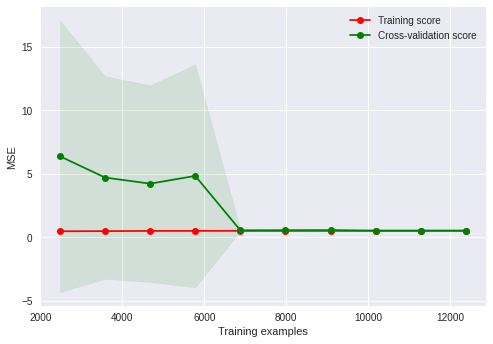

In [41]:
(train_sizes, train_scores, test_scores, fit_times, score_times) = learning_curve(
    lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv,scoring='neg_mean_squared_error',
    n_jobs=-1, return_times=True,train_sizes=np.linspace(0.2,1.0,10))

plot_learning_curve(train_sizes, train_scores, test_scores)

Observe that:
- Both curves have reach the plateau; they're fairly close and fairly high
- Few instances in the training set means the model can fit them perfectly. But as more instances are added to the training set, it becomes impossible for the model to fit the training data perfectly.
- When the model is trained on very few instances, it might not be able to generalize properly, which is why the validation error is initially quite high. Then as the model learns on more training examples. tht training and validation error reduce slowly.

These curves are typical of an underfitting model.
We can also study how model training scales as the function of number of training examples

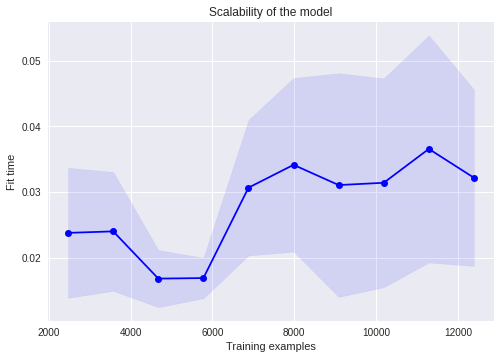

In [42]:
plot_scalability_curve(train_sizes, fit_times)

As the number of training examples grows, the time it takes to fit the model increases.

#### Model examination
Let's examine the weight vectors and how much variability exists between them across different cross-validated models

In [43]:
feature_names = train_features.columns
feature_names

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

For this we will first construct a dataframe of weight vectors and plot them with ``box`` plot.

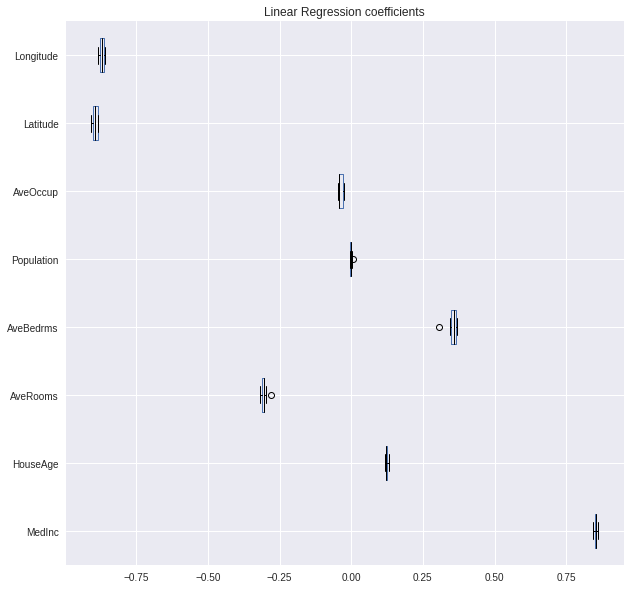

In [48]:
coefs = [est[-1].coef_ for est in lin_reg_cv_results['estimator']]
weights_df = pd.DataFrame(coefs, columns=feature_names)

color= {'whiskers': 'black', 'medians':'black', 'caps':'black'}
weights_df.plot.box(color=color, vert=False, figsize=(10,10))
_ = plt.title('Linear Regression coefficients')

There's not much variability in weights learned by different models. It can also by the standard deviation of weights as seen in ``std`` row below:

In [49]:
weights_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.852153,0.122770,-0.304384,0.353528,-0.001576,-0.037059,-0.894011,-0.869753
std,0.005763,0.004312,0.010998,0.018044,0.003254,0.008582,0.009975,0.009097
min,0.843517,0.117394,-0.318971,0.307474,-0.005787,-0.047584,-0.908058,-0.884206
25%,0.848871,0.119895,-0.310778,0.349715,-0.002688,-0.042486,-0.901411,-0.876542
50%,0.852711,0.121592,-0.305795,0.360139,-0.002063,-0.042325,-0.895370,-0.869631
75%,0.854743,0.125520,-0.302980,0.364646,-0.000350,-0.027562,-0.883967,-0.862110
max,0.861659,0.130560,-0.278426,0.367952,0.005297,-0.026331,-0.881884,-0.857844


#### Selecting the best model
Let's select the best model with the lowest cross validated test error as the best performing model.

In [50]:
best_model_index = np.argmin(test_error)
selected_model = lin_reg_cv_results['estimator'][best_model_index]

Let's examine the coefficients

In [51]:
print('Intercept (w_0): ',selected_model['lin_reg'].intercept_)
print('Coefficients (w_1,w_2,...,w_m): ',selected_model['lin_reg'].coef_)

Intercept (w_0):  2.0779898917958657
Coefficients (w_1,w_2,...,w_m):  [ 8.44324888e-01  1.18463901e-01 -3.04619574e-01  3.56620503e-01
  1.74458509e-04 -4.23964612e-02 -8.96045642e-01 -8.68906479e-01]


#### Model performance
Towards this, let's first obtain the predictions for test points in cross validation

In [52]:
from sklearn.model_selection import cross_val_predict
cv_predictions = cross_val_predict(lin_reg_pipeline, train_features, train_labels)

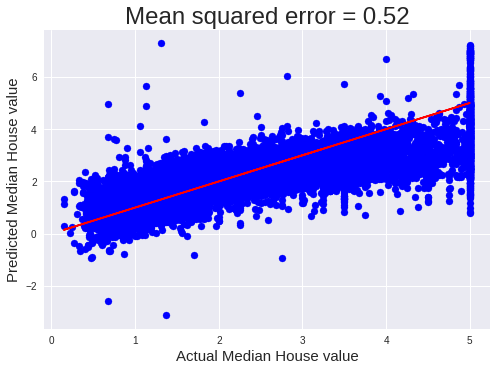

In [53]:
mse_cv = mean_squared_error(train_labels, cv_predictions)

plt.scatter(train_labels, cv_predictions, color='blue')
plt.plot(train_labels, train_labels, 'r-')
plt.title(f'Mean squared error = {mse_cv:.2f}',size=24)
plt.xlabel('Actual Median House value', size=15)
plt.ylabel('Predicted Median House value', size=15)
plt.show()

- The model seems to be all over the place in its predictions for examples with label 5
- There are some negative predictions. We can fix this by adding a constraint on the weights to be positive.

At this stage, we should perform error analysis and check where the predictions are going wrong. We can revisit the feature construction, preprocessing or model stages and make the necessary course corrections to get the better performance.

### **Step 5**: Predictions
We can use the best performing model from cross validation for getting predictions on the test set.

In [54]:
test_predictions_cv = selected_model.predict(test_features)
test_predictions_cv

array([0.73548515, 1.7725621 , 2.70011199, ..., 1.72922496, 2.34393553,
       3.5176306 ])

We can also obtain predictions using the initial model that we built without cross validation

In [55]:
test_predictions = lin_reg_pipeline.predict(test_features)
test_predictions

array([0.72412832, 1.76677807, 2.71151581, ..., 1.72382152, 2.34689276,
       3.52917352])

### **Step 6**: Report Model Performance
We report model performance on the test set.

In [56]:
score_cv = selected_model.score(test_features, test_labels)
score = lin_reg_pipeline.score(test_features, test_labels)

print('R2 score for the best model obtained via Cross Validation:', score_cv)
print('R2 score for model without CV:', score)

R2 score for the best model obtained via Cross Validation: 0.5923577635319088
R2 score for model without CV: 0.5910509795491352


Alternatively we can use any other metric of interest and report performance based on that. For example mean squared error is as follows:

In [57]:
mse = mean_squared_error(test_labels, test_predictions)
mse_cv =mean_squared_error(test_labels, test_predictions_cv)

print('MSE for best model obtained via CV:', mse_cv)
print('MSE for model without CV',mse)

MSE for best model obtained via CV: 0.5393995876218521
MSE for model without CV 0.5411287478470688


The cross validation based model has slightly better MSE than the other model.

**Exercise**:
1. Change the scoring scheme to other scoring metrics provided in [``sklearn.metrics``](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) and compare the results across different metrics
2. Repeat the modeling steps with ``SGDRegressor``. 

## Lecture: 3.4 Baseline models
In this notebook, we will build a couple of baseline models using ``DummyRegression`` and ``permutation_test_score``. We will compare performance of our linear regression model with these two baselines

### Imports

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

We will use ``ShuffleSplit`` as a cross validation strategy

In [60]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

Let's load the data and split it into training and test

In [61]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=42)

### ``LinearRegression`` classifier
- Build linear regression model with feature scaling as a part of pipeline
- Train the model with 10-fold cross validation via ``ShuffleSplit``.
- Capture the errors on different folds.


In [64]:
lin_reg_pipeline = Pipeline([('feature_scaling',StandardScaler()),
                            ('lin_reg',LinearRegression())])

lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    train_features,
                                    train_labels,
                                    cv=shuffle_split_cv,
                                    scoring="neg_mean_absolute_error",
                                    n_jobs=2)

lin_reg_errors = pd.Series(-lin_reg_cv_results['test_score'],name='Linear regression error')

### ``DummyRegressor``

In [67]:
def dummy_regressor_baseline(strategy, constant_val=None, quantile_val=None):
    baseline_model_median = DummyRegressor(strategy=strategy,
                                            constant=constant_val,
                                            quantile=quantile_val)
    
    baseline_median_cv_results = cross_validate(baseline_model_median,
                                                train_features,
                                                train_labels,
                                                cv=shuffle_split_cv,
                                                scoring='neg_mean_absolute_error',
                                                n_jobs=2)
    
    return  pd.Series(-baseline_median_cv_results['test_score'],name='Dummy regressor error')

In [68]:
baseline_median_cv_results_errors = dummy_regressor_baseline(strategy='median')
baseline_mean_cv_results_errors = dummy_regressor_baseline(strategy='mean')
baseline_constant_cv_results_errors = dummy_regressor_baseline(strategy='constant',constant_val=2)
baseline_quantile_cv_results_errors = dummy_regressor_baseline(strategy='quantile',quantile_val=0.55)

Let's compare the performances of these dummy regressors

In [69]:
dummy_error_df = pd.concat([baseline_median_cv_results_errors,
                            baseline_mean_cv_results_errors,
                            baseline_constant_cv_results_errors,
                            baseline_quantile_cv_results_errors],
                            axis=1)
dummy_error_df.columns =['Median CV', 'Mean CV', 'Constant CV', 'Quantile CV']

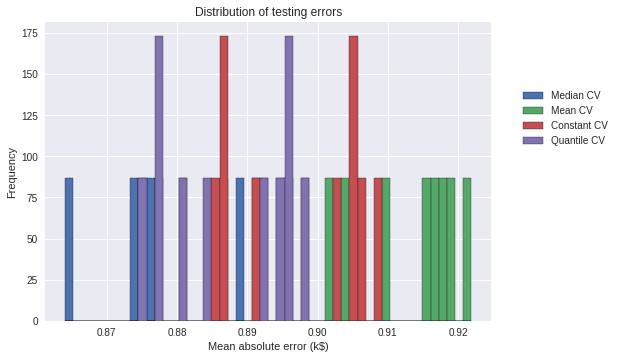

In [70]:
dummy_error_df.plot.hist(bins=50, density=True, edgecolor='black')
plt.legend(bbox_to_anchor=(1.05,0.8), loc='upper left')
plt.xlabel('Mean absolute error (k$)')
_ = plt.title('Distribution of testing errors')

#### ``permutation_test_score``
It permutes the target to generate randomized data and computes the empirical p-value against the null hypothesis, that features and targets are independent.

Here we are interested in ``permutation_score`` returned by this API, which indicates score of the model on different permutations

In [71]:
score, permutation_score, pvalue = permutation_test_score(
    lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv,
    scoring='neg_mean_absolute_error',n_jobs=2, n_permutations=30)
permutation_errors = pd.Series(-permutation_score, name='Permuted error')

In [72]:
print(permutation_score)

[-0.91446539 -0.91608713 -0.91501122 -0.91112203 -0.91326112 -0.91428719
 -0.91694297 -0.90660687 -0.90873595 -0.91546138 -0.9084695  -0.91174023
 -0.91857102 -0.91467076 -0.90396709 -0.91239289 -0.91095499 -0.91729623
 -0.90529415 -0.91436609 -0.91993036 -0.91661883 -0.91104746 -0.91563156
 -0.91014294 -0.91526135 -0.90680247 -0.90796435 -0.91032999 -0.91545574]


#### Model comparision

In [73]:
error_df = pd.concat([lin_reg_errors,baseline_median_cv_results_errors,permutation_errors], axis=1)

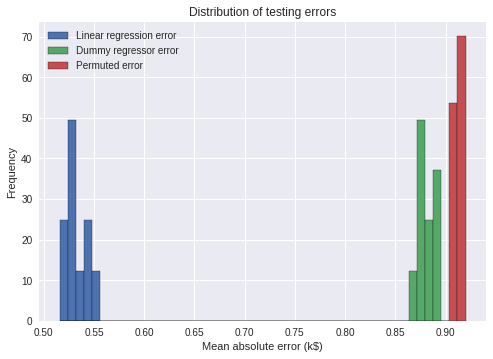

In [74]:
error_df.plot.hist(bins=50,density=True,edgecolor='black')
plt.legend(loc='best')
plt.xlabel('Mean absolute error (k$)')
_ = plt.title('Distribution of testing errors')

Our model has better performance than the two baselines. However our model needs to improve furthur

#### Summary
We implemented a couple of baselines - based on ``DummyRegressor`` and ``permutation_test_score``.
In this notebook we implemented all the strategies for ``DummyRegressor``. While in practice we only use one of these strategies depending on the dataset.

## Lecture 3.5: SGDRegressor Demonstration
### Linear regression with iterative optimization: ``SGDRegressor``
In this notebook, we will build a linear regression model with ``SGDRegressor``. SGD offers a lot of control over optimization procedure through a number of hyperparameters. However, we need to set them to the right values in order to make it work for training the model.

#### Imports

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [80]:
np.random.seed(306)

We will use ``ShuffleSplit`` as a cross validation strategy

In [81]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

Let's load the data and split it into training and test.

In [82]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(
    features, labels, random_state=42)

Divide the data into train and dev sets

In [83]:
train_features, dev_features, train_labels, dev_labels = train_test_split(
    com_train_features, com_train_labels, random_state=42)

### Baseline ``SGDRegressor``
- **STEP 1**: To begin with, we instanstiate a baseline ``SGDRegressor`` model with default parameters.
- **STEP 2**: Train the model with training feature matrix and labels.
- **STEP 3**: Obtain the score on the training and development data

In [85]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))
print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development data:', dev_mae)

Mean absolute error on Training set: 327898229800533.8
Mean absolute error on development data: 331110341291405.44


We can observe that the mean absolute error is too high. The baseline model does not fit well. This may happen due to high learning rate.

Let's investigate this issue by training the model step by step and recording training loss in each step.
### Adding a feature scaling step.
SGD is sensitive to feature scaling. Let's add a feature scaling step and check if we get better MAE

In [86]:
sgd_pipeline = Pipeline([('feature_scaling',StandardScaler()),
                        ('sgd',SGDRegressor())])
sgd_pipeline.fit(train_features, train_labels)


train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development data:', dev_mae)

Mean absolute error on Training set: 0.5135804404077051
Mean absolute error on development data: 0.6373131245753217


The error is still high, let's run ``SGDRegressor`` step by step and investigate the issues with training.

### Step-wise training of ``SGDRegressor``
- **STEP 1**: Instantiate ``SGDRegressor`` with ``warm_start=True`` and ``tol=-np.infty``
- **STEP 2**: Train SGD step by step and record regression loss in each step.
- **STEP 3**: Plot learning curves and see if there are any issues in training.

Text(0.5, 1.0, 'Learning curve: eta0=0.0100')

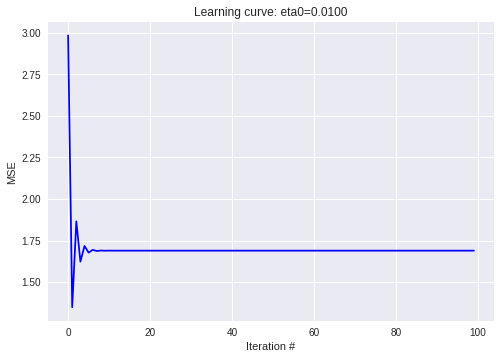

In [97]:
eta0 = 1e-2
sgd_pipeline = Pipeline([('feature_scaling',StandardScaler()),
                        ('sgd',SGDRegressor(max_iter=1,
                                            tol= -np.infty,
                                            warm_start=True,
                                            eta0=eta0,
                                            random_state=42))])
loss = []
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels) # Continues where it left off
    loss.append(mean_squared_error(train_labels,
                                    sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration #')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

The loss reduced initially and then increased. This could be due to large learning rates by a factor of 10 and retry the training

Text(0.5, 1.0, 'Learning curve: eta0=0.0010')

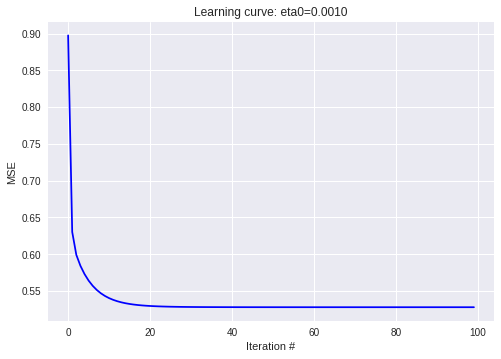

In [101]:
eta0 = 1e-3
sgd_pipeline = Pipeline([('feature_scaling',StandardScaler()),
                        ('SGD',SGDRegressor(max_iter=1,
                                            tol= -np.infty,
                                            warm_start=True,
                                            eta0=eta0,
                                            random_state=42))])
loss = []
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels) # Continues where it left off
    loss.append(mean_squared_error(train_labels,
                                    sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration #')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

This is an ideal training curve where the train loss reduces monotonically as the training progresses.

In [102]:
print('Number of iterations before reaching convergence criteria:', sgd_pipeline[-1].n_iter_)
print('Number of weight updates:',sgd_pipeline[-1].t_)

Number of iterations before reaching convergence criteria: 1
Number of weight updates: 11611.0


In [103]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development set:', dev_mae)

Mean absolute error on Training set: 0.5333732983042573
Mean absolute error on development set: 0.5190150280908042


### Fixing learning rate through validation curves
- **STEP 1**: Provide the list of values to be tried for a hyper parameter
- **STEP 2**: Instantiate an object of ``validation_curve`` with estimator, training features and label. Set ``scoring`` parameter to relevant score.
- **STEP 3**: Convert scores to error
- **STEP 4**: Plot validation curve with the value of hyper-parameter on x-axis and error on the y-axis.
- **STEP 5**: Fix the hyper-parameter value where the test error is the least.

In [104]:
%%time

eta0 = [1e-5, 1e-4, 1e-3, 1e-2]

train_scores , test_scores = validation_curve(
    sgd_pipeline, com_train_features, com_train_labels, param_name='SGD__eta0',
    param_range=eta0, cv=shuffle_split_cv, scoring='neg_mean_squared_error',
    n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

CPU times: user 210 ms, sys: 52.6 ms, total: 263 ms
Wall time: 3.71 s


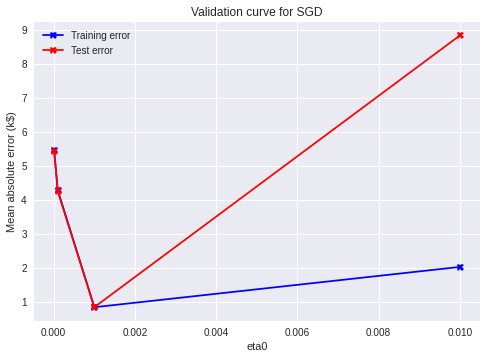

In [108]:
train_errors, test_errors = -train_scores, -test_scores
plt.plot(eta0, train_errors.mean(axis=1), 'b-X', label='Training error')
plt.plot(eta0, test_errors.mean(axis=1), 'r-X',label='Test error')
plt.legend()
plt.xlabel('eta0')
plt.ylabel('Mean absolute error (k$)')
_ = plt.title('Validation curve for SGD')

For ``eta0 = 1e-3``, the test error is the least hence we select the value as the value for eta0.

Next we also plot standard deviation in errors.

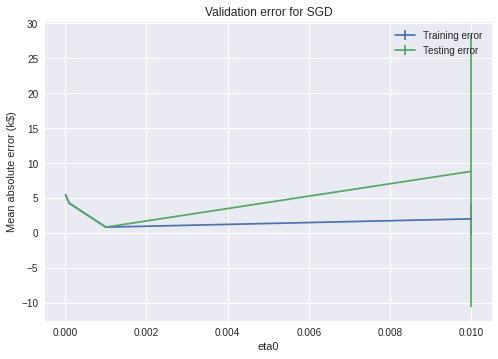

In [110]:
plt.errorbar(eta0, train_errors.mean(axis=1),
            yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(eta0, test_errors.mean(axis=1),
            yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()
plt.xlabel('eta0')
plt.ylabel('Mean absolute error (k$)')
_ = plt.title('Validation error for SGD')

### ``SGDRegressor``

In [112]:
sgd_pipeline = Pipeline([('feature_scaling',StandardScaler()),
                        ('sgd',SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            tol= -1e-3,
                                            eta0=1e-3,
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])
sgd_pipeline.fit(train_features,train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development set:', dev_mae)

Mean absolute error on Training set: 0.579376454514559
Mean absolute error on development set: 0.5689180241137523


In [113]:
print('Number of iterations before reaching convergence criteria:', sgd_pipeline[-1].n_iter_)
print('Number of weight updates:',sgd_pipeline[-1].t_)

Number of iterations before reaching convergence criteria: 7
Number of weight updates: 81271.0


In [114]:
sgd_pipeline = Pipeline([('feature_scaling',StandardScaler()),
                        ('sgd',SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            tol= -1e-3,
                                            eta0=1e-3,
                                            learning_rate='constant',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])
sgd_pipeline.fit(train_features,train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development set:', dev_mae)

print('Number of iterations before reaching convergence criteria:', sgd_pipeline[-1].n_iter_)
print('Number of weight updates:',sgd_pipeline[-1].t_)

Mean absolute error on Training set: 0.5359339681114987
Mean absolute error on development set: 0.5151099728924146
Number of iterations before reaching convergence criteria: 8
Number of weight updates: 92881.0


In [115]:
sgd_pipeline = Pipeline([('feature_scaling',StandardScaler()),
                        ('sgd',SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            tol= -1e-3,
                                            eta0=1e-3,
                                            learning_rate='adaptive',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])
sgd_pipeline.fit(train_features,train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development set:', dev_mae)

print('Number of iterations before reaching convergence criteria:', sgd_pipeline[-1].n_iter_)
print('Number of weight updates:',sgd_pipeline[-1].t_)

Mean absolute error on Training set: 0.5340193046836148
Mean absolute error on development set: 0.5198356196858102
Number of iterations before reaching convergence criteria: 33
Number of weight updates: 383131.0


### Setting ``max_iters``

In [116]:
max_iter = np.ceil(1e6/com_train_features.shape[0])
max_iter

65.0

In [117]:
sgd_pipeline = Pipeline([('feature_scaling',StandardScaler()),
                        ('sgd',SGDRegressor(max_iter=max_iter,
                                            early_stopping=True,
                                            tol= -1e-3,
                                            eta0=1e-3,
                                            learning_rate='constant',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])
sgd_pipeline.fit(train_features,train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development set:', dev_mae)

print('Number of iterations before reaching convergence criteria:', sgd_pipeline[-1].n_iter_)
print('Number of weight updates:',sgd_pipeline[-1].t_)

Mean absolute error on Training set: 0.5359339681114987
Mean absolute error on development set: 0.5151099728924146
Number of iterations before reaching convergence criteria: 8
Number of weight updates: 92881.0


#### Summary
In this notebook, we saw:
- How to build ``SGDRegressor`` model
- How to tune the learning rate
- How to use different ``learning_rates`` and their impact on convergence
- How to use early stopping and averaged SGD
- How to tune hyperparameters with validation curves